Please download the file "trainset.csv" and save it into same folder as this notebook.

The two files are the training and test sets created from the California housing dataset.

In [1]:
# setting logging to print only error messages
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(palette="Set2")

# Polynomial Regression

As we saw in experiments with Linear Regression on the California housing data, it performs quite poorly, as it is relies on the assumption that the price of a house can be described as a **linear combination** of some other variables, that is the target variable `y` can be predicted from:

$y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$

But if the target does not appear to be linearly dependent on other variable, one can attempt to fit a non-linear model. This can be achieved by adding extra variables which are the original variables taken to a power:

$y = \alpha + \beta_1 x_1 + \beta_2 x_1^2 + \beta_3 x_2 + \beta_4 x_2^2 + ... $

Let's take a look at an example.

In [2]:
# number of points
m = 100

# x coordinates: -3 + 6 * an array with the shape (100, 1)
# containing random numbers between 0 and 1
X = 6 * np.random.rand(m, 1) - 3

# y coordinates
y = 2 + 0.5 * X**2 + X + np.random.randn(m, 1)

So we've generated points using this equation:

$y = 2 + 0.5x^2 + x + e$

where $e$ is a certain random amount between 0 and 1.

In [3]:
X.shape

(100, 1)

There are 100 rows in one column in the array `X`.

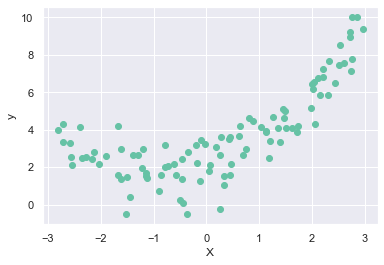

In [4]:
# plot the points
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Clearly, a linear model will not fit the data points well.

We can use Scikit-Learn’s `PolynomialFeatures` class to adding the square (2nd-degree polynomial) of each feature (in this case the single feature, `X`):

In [5]:
from sklearn.preprocessing import PolynomialFeatures

# initialize transformer (include_bias set to False not to add an extra column of 1's)
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# fit the transformer and immediately use it to transform X:
X_poly = poly_features.fit_transform(X)

X_poly.shape

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(100, 2)

`X_poly` now contains 100 rows and two columns: the first column is the original value in `X` and the second column is its square:

In [6]:
# the first row
X_poly[0]

array([-0.86883516,  0.75487454])

Now we can fit a linear regression to `X`:

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

lin_reg.intercept_, lin_reg.coef_

(array([2.0571511]), array([[0.88937725, 0.52552283]]))

So the estimated equation is:

$y = 2.11 + 0.97x + 0.5x^2$

I.e., the fitted equation was able to largely recover the formula we used to generate the data originally.

We can also plot the fitted regression:

In [8]:
Xf = np.arange(-3, 3, 0.01)
yf = 2.11 + 0.5 * Xf**2 + 0.97 * Xf

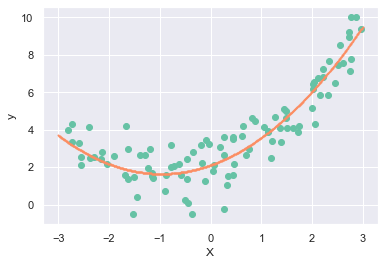

In [9]:
plt.scatter(X, y)
plt.scatter(Xf, yf, s=1)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Let's fit a polynomial regression to the training part of the housing dataset. We will use the 7 most useful features found by the Random Forest algorithm in "Housing.ipynb".

In [10]:
usecols = ["median_income", "INLAND", "population_per_household", "longitude", "latitude", 
           "housing_median_age", "rooms_per_household", "median_house_value"]
trainset = pd.read_csv("datasets/trainset.csv", usecols=usecols)

Separate `X` and `y`:

In [11]:
Xtrain = trainset.drop("median_house_value", axis=1)

ytrain = trainset["median_house_value"].copy()

In [12]:
Xtrain.shape

(15736, 7)

There are 7 predictor features in the dataset. We will create third-degree polynomial features. Note that `PolynomialFeatures` also creates **interaction features**, which makes it possible to capture possible interactions between individual predictor features. For example, if there are two features $a$ and $b$ in the dataset, `PolynomialFeatures` will create not only $a^2$ and $b^2$, but also the interaction feature $ab$.

The addition of interaction features is meant to account for the possibility that two features may amplify or diminish each other's effect on the target variable. If the estimated coefficients on such interaction features are statistically significant, this is an indication about the joint effect of the features.

A useful option in `PolynomialFeatures` is `interaction_only`: if the argument set to `True`, only interaction features will be generated. For example, for $a$ and $b$ only $ab$ will be added.

We first create polynomial features:

In [13]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(Xtrain)

In [14]:
X_poly.shape

(15736, 119)

Thus, `PolynomialFeatures` increased the number of features from 7 to 119. Beware of applying this transformation to datasets containing many variables and/or using high-degree polynomial features, as the number of features will explode!

We can look up the names of features that have been created:

In [15]:
print(poly_features.get_feature_names_out(input_features=Xtrain.columns))

['longitude' 'latitude' 'housing_median_age' 'median_income'
 'rooms_per_household' 'population_per_household' 'INLAND' 'longitude^2'
 'longitude latitude' 'longitude housing_median_age'
 'longitude median_income' 'longitude rooms_per_household'
 'longitude population_per_household' 'longitude INLAND' 'latitude^2'
 'latitude housing_median_age' 'latitude median_income'
 'latitude rooms_per_household' 'latitude population_per_household'
 'latitude INLAND' 'housing_median_age^2'
 'housing_median_age median_income'
 'housing_median_age rooms_per_household'
 'housing_median_age population_per_household' 'housing_median_age INLAND'
 'median_income^2' 'median_income rooms_per_household'
 'median_income population_per_household' 'median_income INLAND'
 'rooms_per_household^2' 'rooms_per_household population_per_household'
 'rooms_per_household INLAND' 'population_per_household^2'
 'population_per_household INLAND' 'INLAND^2' 'longitude^3'
 'longitude^2 latitude' 'longitude^2 housing_median_ag

We will train and evaluate both a linear and a polynomial model, with the same setting: one train-test split, validation set size is 10% of the training set.

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def evaluate_model(model, X, y):
    """Given a model object, predictors and the target, fit and evaluate a model,
    output its RMSE on the training set and on the validation set
    """

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)

    # record the results
    train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train))
    val_rmse = np.sqrt(mean_squared_error(y_val_predict, y_val))
    
    return train_rmse, val_rmse

poly_reg = LinearRegression()
train_rmse, val_rmse = evaluate_model(poly_reg, X_poly, ytrain)
print(f"Polynomial: Train: {train_rmse}, validation: {val_rmse}")

Polynomial: Train: 53398.48207089356, validation: 55266.86021529713


In [17]:
lin_reg = LinearRegression()
train_rmse, val_rmse = evaluate_model(lin_reg, Xtrain, ytrain)
print(f"Linear: Train: {train_rmse}, validation: {val_rmse}")

Linear: Train: 63742.73526194295, validation: 65459.24504863792


These results indicate that the polynomial model fitted both the training and the validation sets better than the linear one. Because polynomial models have a much larger number of parameters, including non-linear ones, they generally tend to overfit training data. In these results, however, there is no evidence of strong overfitting of the polynomial model.

# Learning Curve

One useful way to detect over- and underfitting is to plot a **learning curve**. A learning curve plot shows the model's performance on the training and validation sets as a function of the amount of data used for training.

The learning curve can be plotted using this code:

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y):
    
    # create a train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)
    train_errors, val_errors, sizes = [], [], []
    
    # take different sizes of the training data, starting from 50s instance, with the step of 10
    for m in range(50, len(X_train), 10):
        
        # fit a model
        model.fit(X_train[:m], y_train[:m])
        
        # evaluate the model on both training and validation sets
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        # calculate RMSE and record the results
        train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train[:m]))
        val_rmse = np.sqrt(mean_squared_error(y_val_predict, y_val))
        
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
        sizes.append(m)
        
    # make a plot
    temp_df = pd.DataFrame({"training set size": sizes, 
                        "train": train_errors,
                        "val": val_errors})
    temp_df.plot(x="training set size", y=["train", "val"], kind="line", 
             figsize=(6, 4), ylim=(40000, 80000))

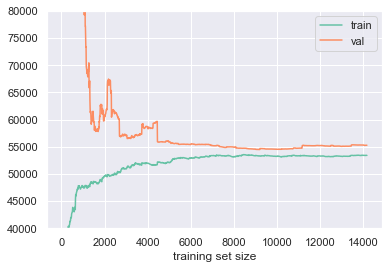

In [19]:
# linear curve for the polynomial model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_poly, ytrain)

Initially, the polynomial model overfits a lot: it fits the training data really well (at under 2,000 instances RMSE stays below 50k), and performs very poorly on the validation data (RMSE well above 80k). As the training data size increases, the two curves start to converge, with the validation curve very gradually decreasing. This shows that the addition of extra training data helps to fit better models, and the degree of overfitting gets smaller. More data might help to decrease the error rate even further, although not by a lot: the validation curve appears to stabilize soon.

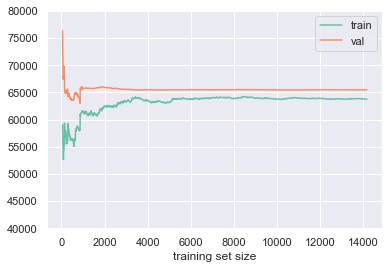

In [20]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, Xtrain, ytrain)

With, linear regression, one can notice that in the beginning, at smaller sizes of training data, the model overfits a little (the training set performance is mainly below 60k, while performance on validation is over 65k at very small sizes of training data; the validation error rate is never as high as with the polynomial model). As the size of the training data increases, the validation set performance stabilizes very quickly and stays on the same level. The training set performance also plateaus at some point and does not change much any more. This indicates that adding more training data will not improve the performance on the validation set.

# Ridge Regression

The cost function in Ridge Regression is the sum of squared errors plus a penalty term, which is the sum of squared coefficients:

$\underset{\beta}{\mathrm{argmin}} \sum^{Y}\limits_{i=1} (y_i - \alpha - \sum^{X}\limits_{j=1}\beta_{j} x_{i,j})^2 + \lambda  \sum^{X}\limits_{i=j}\beta_{j}^2$

Plot its learning curve:

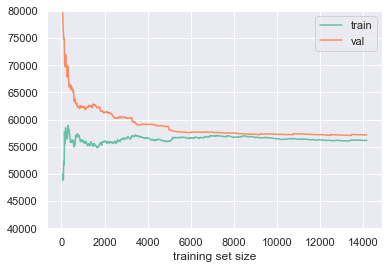

In [21]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# first standartize X_poly
scaler = StandardScaler()
X_poly_st = scaler.fit_transform(X_poly)

ridge = Ridge(random_state=7, alpha=50)
plot_learning_curves(ridge, X_poly_st, ytrain)

Train and evaluate a Ridge regression model:

In [22]:
ridge = Ridge(random_state=7, alpha=50)
train_rmse, val_rmse = evaluate_model(ridge, X_poly_st, ytrain)
print(f"Ridge: Train: {train_rmse}, validation: {val_rmse}")

Ridge: Train: 56168.051205293166, validation: 57181.66449746129


# LASSO

The cost function in LASSO Regression is the sum of squared errors plus a penalty term, which is the sum of the absolute values of the coefficients:

$\underset{\beta}{\mathrm{argmin}} \sum^{Y}\limits_{i=1} (y_i - \alpha - \sum^{X}\limits_{j=1}\beta_{j} x_{i,j})^2 + \lambda  \sum^{X}\limits_{i=j}|\beta_{j}|$

In [23]:
from sklearn.linear_model import Lasso

# this takes way too long!
#lasso = Lasso(random_state=7, alpha=1, max_iter=100000)
#plot_learning_curves(lasso, X_poly_st, ytrain)

Train and evaluate a LASSO model (it will take an hour of so):

In [24]:
lasso = Lasso(random_state=7, alpha=0.1, max_iter=1000000)
train_rmse, val_rmse = evaluate_model(lasso, X_poly_st, ytrain)
print(f"Lasso: Train: {train_rmse}, validation: {val_rmse}")

Lasso: Train: 54846.5069032713, validation: 55732.62953776444


Display estimated coefficients on the features. The `coef_` attribute of a `Lasso` object holds the feature coefficients.

In [25]:
lasso.coef_.shape

(119,)

We use the absolute values of the coefficients to determine importance of the features, and then sort them in the descending order (`reverse=True`) to find the most important ones, and in the ascending order (`reverse=False`) to find deleted ones.

In [26]:
abs_scores = np.abs(lasso.coef_)
poly_feature_names = poly_features.get_feature_names_out(input_features=Xtrain.columns)

for score, name in sorted(zip(abs_scores, poly_feature_names), reverse=True):
    print(f"{name}: {score}")

population_per_household^2: 432483.6754074234
latitude population_per_household^2: 292741.6623782751
population_per_household: 251822.101834846
rooms_per_household population_per_household^2: 247839.7309149113
latitude population_per_household: 163230.7992629211
population_per_household^3: 142528.28943733426
median_income population_per_household INLAND: 119820.14167212452
population_per_household INLAND: 118047.64977626466
latitude rooms_per_household population_per_household: 103840.7736954994
latitude median_income population_per_household: 99537.53386138174
housing_median_age population_per_household: 97408.98505569118
rooms_per_household^2 INLAND: 97189.86078259867
median_income population_per_household: 95334.19306862148
longitude latitude population_per_household: 82568.63500381938
latitude median_income: 76896.15757324755
longitude median_income: 73086.91451132299
latitude: 70826.49962565996
longitude rooms_per_household population_per_household: 70197.7572698844
longitude^2 po

# Acknowledgement

The notebook is based on the code examples from [Aurélien Géron's textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow".


# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
